In [20]:
import  pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
import warnings

from openpyxl import load_workbook



In [9]:
data=pd.read_excel("AirQualityUCI.xlsx")

In [10]:
data['Datetime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'].astype(str), format='%Y-%m-%d %H:%M:%S')
data.set_index('Datetime', inplace=True)
data.drop(columns=['Date', 'Time'], inplace=True)

Decomposing: CO(GT)


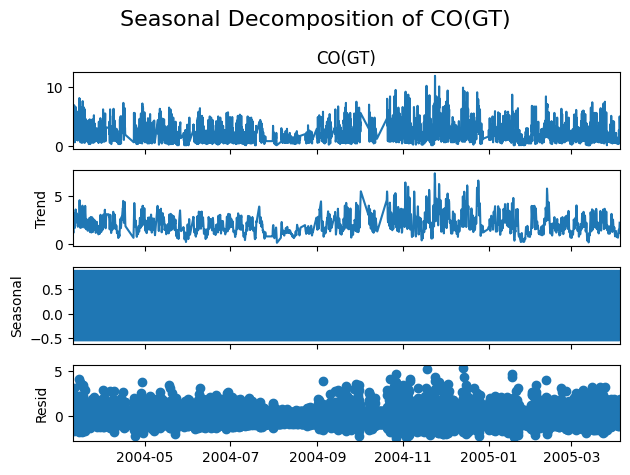

Decomposing: PT08.S1(CO)


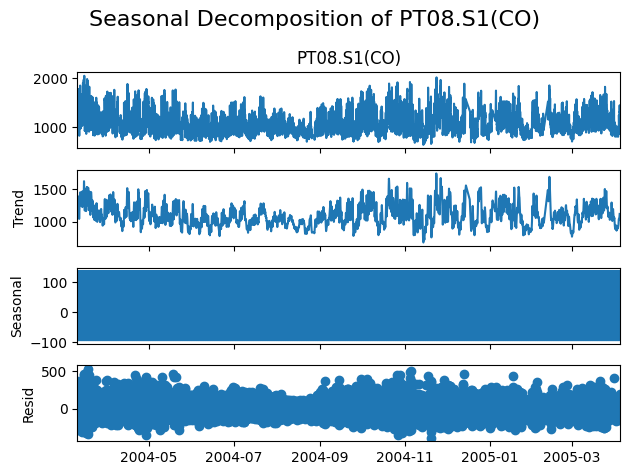

Decomposing: NMHC(GT)


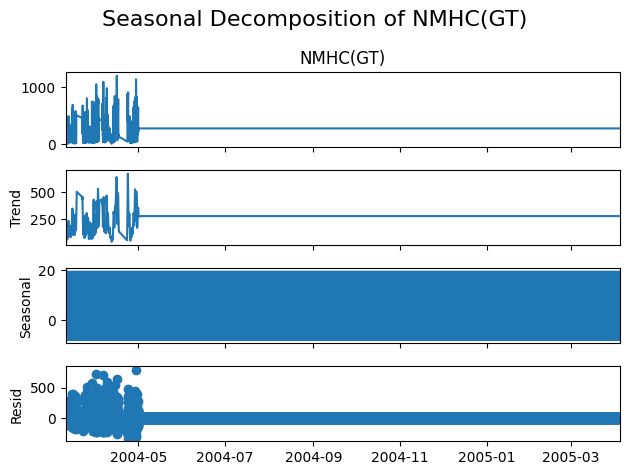

Decomposing: C6H6(GT)


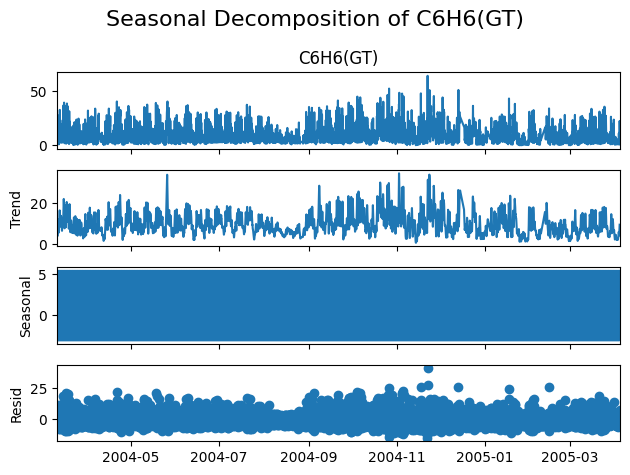

Decomposing: PT08.S2(NMHC)


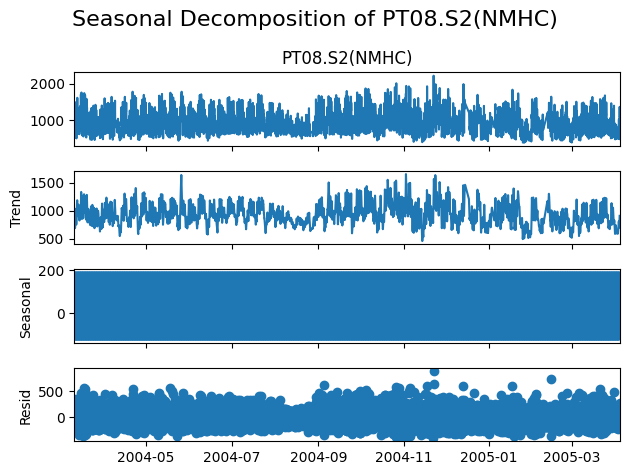

Decomposing: NOx(GT)


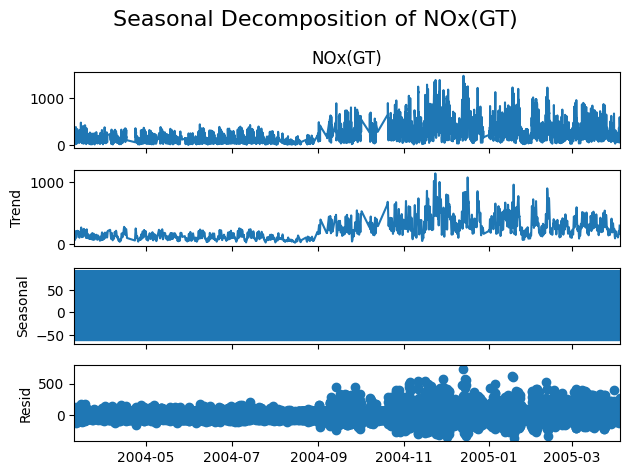

Decomposing: PT08.S3(NOx)


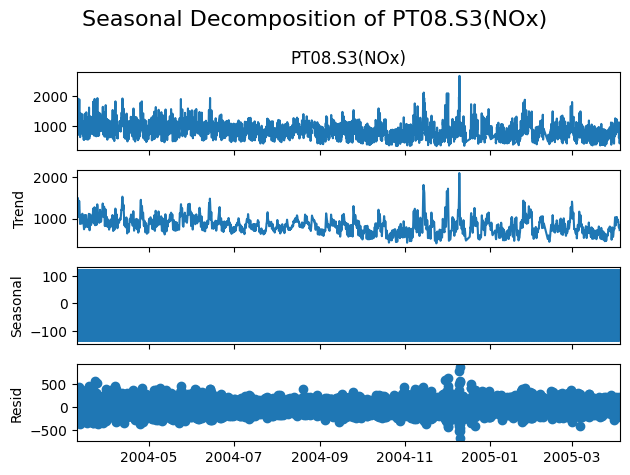

Decomposing: NO2(GT)


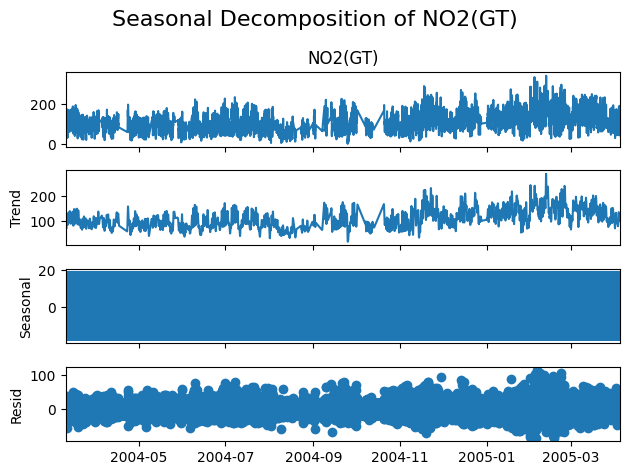

Decomposing: PT08.S4(NO2)


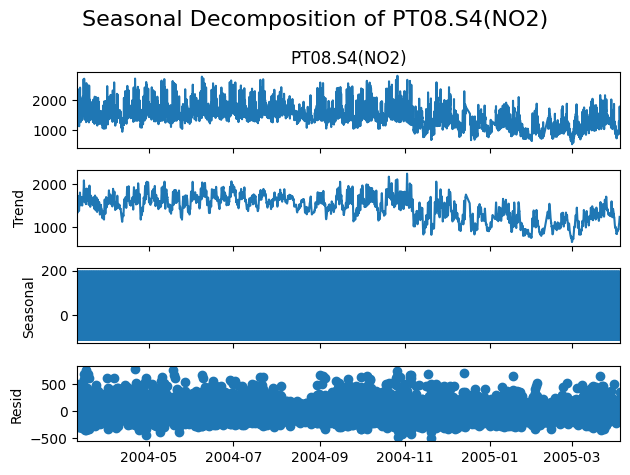

Decomposing: PT08.S5(O3)


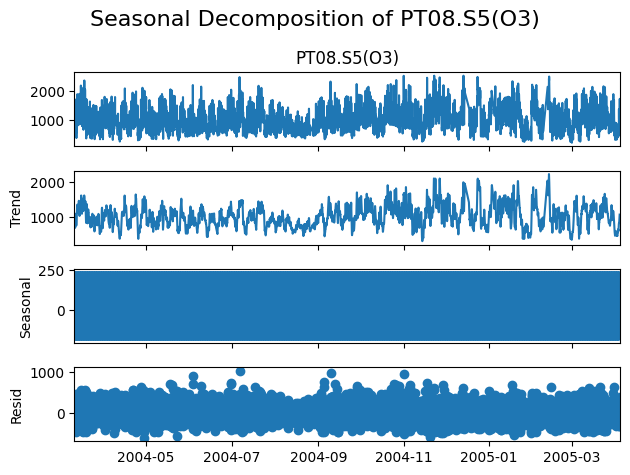

Decomposing: T


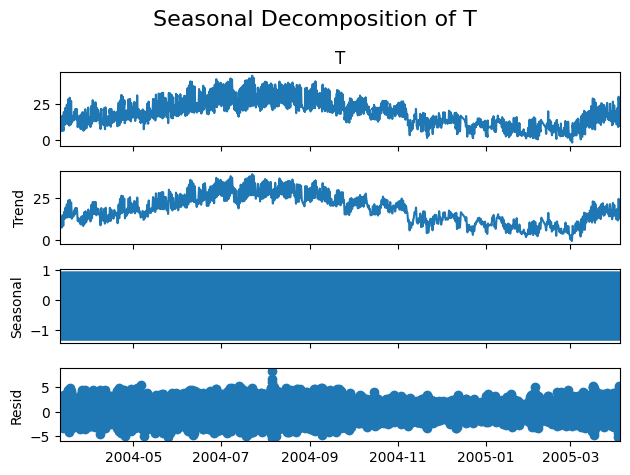

Decomposing: RH


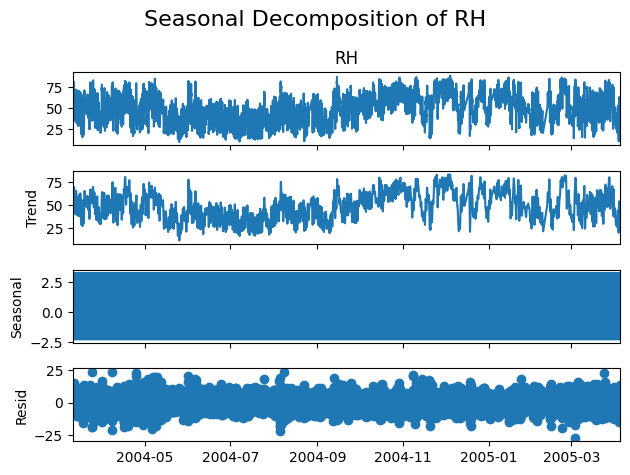

Decomposing: AH


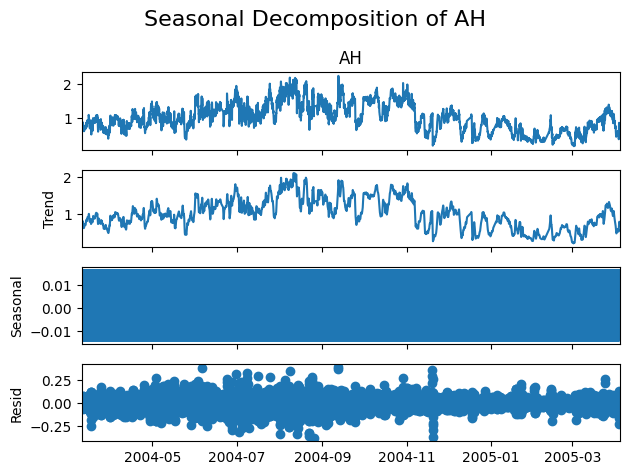

In [11]:
data.replace(-200, np.nan, inplace=True)
col_to_decompose=['CO(GT)','PT08.S1(CO)','NMHC(GT)','C6H6(GT)','PT08.S2(NMHC)','NOx(GT)','PT08.S3(NOx)','NO2(GT)','PT08.S4(NO2)','PT08.S5(O3)','T','RH','AH']
data.interpolate(method='linear', inplace=True)
for col in col_to_decompose:
  print(f"Decomposing: {col}")
  decomposition = sm.tsa.seasonal_decompose(data[col],period=12)
  fig=decomposition.plot()
  fig.suptitle(f'Seasonal Decomposition of {col}', fontsize=16)
  plt.tight_layout()
  plt.show()

In [12]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [22]:
all_preds=pd.DataFrame()
for col in col_to_decompose:
  decomp =seasonal_decompose(data[col],model='additive',period=12)
  residual=data[col]-decomp.trend-decomp.seasonal
  residual=residual.dropna()

  result=adfuller(residual)

  adf_stat=result[0]
  p_val=result[1]

  #print('ADF Statistic:',adf_stat)
  #print('p-value:',p_val)
  if(p_val<0.05):
    model=auto_arima(
        data[col],
        seasonal=False,
        stepwise=True,
        suppress_warnings=True,
        trace=True,
        max_order=None
    )
    print(model.summary())
    future_preds=model.predict(n_periods=48)
    all_preds[col]=future_preds




Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19234.009, Time=17.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21009.233, Time=0.58 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20539.183, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20373.924, Time=1.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21007.233, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=19288.047, Time=13.64 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19257.439, Time=12.92 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=19234.751, Time=21.90 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=19235.742, Time=23.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20346.819, Time=2.58 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=19241.062, Time=17.59 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=19235.272, Time=15.64 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=19235.810, Time=24.37 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=19232.009, Time=3.67 sec
 ARIMA(1,1,

In [25]:
all_preds.to_excel('submission.xlsx', index=False)

In [27]:
split_idx = int(len(data) * 0.9)
rmse={}

for col in col_to_decompose:
  train, test = data[col][:split_idx], data[split_idx:]
  model = auto_arima(
    train,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    trace=True
  )
  # Forecast for the length of the test set
  n_periods = len(test)
  forecast = model.predict(n_periods=n_periods)

  # Calculate RMSE
  rmse[col] = np.sqrt(mean_squared_error(test[col], forecast))
  print(f'RMSE for {col}:{rmse[col]}')


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17245.185, Time=20.01 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18734.440, Time=0.53 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18353.595, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18222.778, Time=1.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18732.441, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17280.828, Time=9.75 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17264.204, Time=11.31 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=17244.736, Time=18.62 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=17246.639, Time=13.81 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=17246.335, Time=23.10 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=17245.380, Time=24.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=16.54 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=17246.731, Time=23.43 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=17248.014, Time=24.95 sec
 ARIMA(3,1,2)(0,

/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,1,3)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/usr/local/lib/python3.11/dist-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/mlemodel.py", line 705, in fit
    mlefit = super().fit(start_pa

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=109823.341, Time=1.81 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=109050.125, Time=18.89 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=108939.172, Time=9.83 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=108922.044, Time=21.88 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=108924.243, Time=24.64 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=108923.591, Time=26.18 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=108925.273, Time=23.17 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=22.15 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=108925.411, Time=28.83 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=108919.466, Time=10.34 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=108925.017, Time=10.25 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=108959.140, Time=4.18 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=108922.239, Time=11.68 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=108921.464,

In [28]:
for i in rmse:
  print(f"{i}:{rmse[i]}")

CO(GT):1.3408018192626796
PT08.S1(CO):202.55776348984904
NMHC(GT):0.0
C6H6(GT):6.571811878106309
PT08.S2(NMHC):249.1878664855678
NOx(GT):181.41839455672658
PT08.S3(NOx):223.38272226292477
NO2(GT):68.6855613844617
PT08.S4(NO2):286.38134794654394
PT08.S5(O3):424.3596349791642
T:9.567113563402819
RH:23.79894681182536
AH:0.288644036900795
